<a href="https://colab.research.google.com/github/njmarko/gat-or/blob/master/gat_or.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GATor

GATor is a Graph Attention Network for object detection with relational reasoning.

### Authors:
 - Marko Njegomir
 - Dušan Erdeljan

## OUR LOWBUDGET GPU

In [37]:
import torch
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

### Installing dependencies and downloading dataset

In [1]:
!python -c "import torch; print(torch.__version__)"
# These two command are used for googlecolab. They should not be run on cloud
!pip uninstall opencv-python-headless -y
!pip install opencv-python-headless==4.1.2.30

!pip install fiftyone
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-geometric
!pip install pycocotools

### Cloning TorchVision utilities

In [4]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git --branch  v0.8.2

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [5]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.coco as fouc
from fiftyone import ViewField as VF
import numpy as np
from itertools import product
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.transforms import functional as TVF
from torchvision.ops import box_iou
from torchvision.ops import boxes as box_ops
from PIL import Image
import matplotlib.pylab as plt
import matplotlib.patches as patches
from matplotlib.pyplot import figure
import torch_geometric as pyg
import torch_geometric.data as pyg_data
from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing

from engine import train_one_epoch, evaluate
from transforms import Compose, ToTensor
import utils

import math
import os
import os.path as osp

### Download COCO2017 train set

In [6]:
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
#     max_samples=200,
)
dataset.persistent = True

Found annotations at '/home/njmarko1991/fiftyone/coco-2017/raw/instances_train2017.json'
Images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Download COCO2017 validation set

In [7]:
dataset_validation = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
)
dataset_validation.persistent = True

Found annotations at '/home/njmarko1991/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Inspect dataset in Fiftyone client 

In [ ]:
# session = fo.launch_app(dataset)

### Visualizing co-occurrence matrix

In [8]:
class_names = ['background','person','bicycle','car','motorcycle','airplane','bus','train','truck','boat','traffic light','fire hydrant','street sign','stop sign','parking meter','bench','bird','cat','dog','horse',
'sheep','cow','elephant','bear','zebra','giraffe','hat','backpack','umbrella','shoe','eye glasses','handbag','tie','suitcase','frisbee','skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard',
'surfboard','tennis racket','bottle','plate','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','couch','potted plant','bed',
'mirror','dining table','window','desk','toilet','door','tv','laptop','mouse','remote','keyboard','cell phone','microwave','oven','toaster','sink','refrigerator','blender','book','clock','vase','scissors','teddy bear',
'hair drier','toothbrush','hair brush'
]

class_name_to_idx = {elem:idx for idx, elem in enumerate(class_names)}
n_classes = len(class_names)

In [9]:
co_occurrence_matrix = np.zeros((n_classes, n_classes))

with fo.ProgressBar() as pb:
  for sample in pb(dataset):
    detections = sample.ground_truth.detections
    for attention_pair in product(detections, detections):
      i = class_name_to_idx[attention_pair[0].label]
      j = class_name_to_idx[attention_pair[1].label]
      co_occurrence_matrix[i][j] += 1
      co_occurrence_matrix[j][i] += 1

normalized_matrix = co_occurrence_matrix / np.amax(co_occurrence_matrix + 1.0, axis=1)

figure(figsize=(20, 20), dpi=80)
ax = sns.heatmap(normalized_matrix, linewidth=0.5, xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.show()

### Defining PyTorch dataset

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

#### Resizing of input images and corresponding bbox targets

In [11]:
class Resize(object):
  def __init__(self, size, interpolation=TVF.InterpolationMode.BILINEAR, max_size=None, antialias=None):
    self.size = size
    self.max_size = max_size
    self.interpolation = interpolation
    self.antialias = antialias

  def __call__(self, image, target):
    # Implemented rescaling in matrix form to speed up computation significantly 
    assert torch.is_tensor(image), "Image is expected to be of type torch.tensor"
    original_shape = image.shape
    image = TVF.resize(image, self.size, self.interpolation, self.max_size, self.antialias)
    transformed_shape = image.shape
    x_scale = transformed_shape[2] / original_shape[2]
    y_scale = transformed_shape[1] / original_shape[1]
    scale_tensor = torch.tensor([x_scale, y_scale]).repeat(target['boxes'].shape[0], 2)
    target['boxes'] = torch.mul(target['boxes'], scale_tensor)
    # Added ones to the target boxes width and high to ensure that bboxes would be at least 1x1 dim
    target['boxes'] = target['boxes'] + torch.tensor([0.,0.,1.,1.])
    return image, target

#### Loading data in coco format

In [12]:
class TorchCocoDataset(torch.utils.data.Dataset):
  def __init__(self, fiftyone_dataset, transforms=None, gt_field="ground_truth"):
    self.samples = fiftyone_dataset
    self.transforms = transforms
    self.gt_field = gt_field
    self.img_paths = self.samples.values("filepath")
    self.classes = class_names
    self.labels_map_rev = class_name_to_idx

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    sample = self.samples[img_path]
    metadata = sample.metadata
    img = Image.open(img_path).convert("RGB")

    boxes = []
    labels = []
    area = []
    iscrowd = []
    detections = sample[self.gt_field].detections

    for det in detections:
      category_id = self.labels_map_rev[det.label]
      coco_obj = fouc.COCOObject.from_label(
          det, metadata, category_id=category_id,
      )
      x, y, w, h = coco_obj.bbox
      boxes.append([x, y, x + w, y + h])
      labels.append(coco_obj.category_id)
      area.append(coco_obj.area)
      iscrowd.append(coco_obj.iscrowd)

    target = {}
    target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
    target["image_id"] = torch.as_tensor([idx])
    target["area"] = torch.as_tensor(area, dtype=torch.float32)
    target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

    if self.transforms:
        img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.img_paths)

  def get_classes(self):
    return self.classes

#### Filtering out images with no bboxes and selecting train and validation split

In [13]:
has_bounding_box_view = dataset.filter_labels(
        "ground_truth",
        VF("label").is_in(class_names)
)
has_bounding_box_view_validation = dataset_validation.filter_labels(
        "ground_truth",
        VF("label").is_in(class_names)
)

train_transforms = Compose([ToTensor(), Resize(size=(512, 512))])
test_transforms = Compose([ToTensor()])

# For testing quickly in colab (peasants without v100 only)
# train_view = has_bounding_box_view.take(150, seed=51)
# test_view = has_bounding_box_view.exclude([s.id for s in train_view])

# all images
train_view = has_bounding_box_view
test_view = has_bounding_box_view_validation

print(f"Number of training samples: {len(train_view)}")
print(f"Number of test samples: {len(test_view)}")

torch_dataset_train = TorchCocoDataset(train_view, train_transforms)
torch_dataset_test = TorchCocoDataset(test_view, test_transforms)

Number of training samples: 117266
Number of test samples: 4952


#### Draw example image and bboxes to make sure that resize works

In [14]:
def draw_image_with_bounding_boxes(image, target):
  fig, ax = plt.subplots()
  ax.imshow(image.permute(1, 2, 0))
  for box in target['boxes']:
    x = box[0]
    y = box[1]
    h = box[2] - x
    w = box[3] - y
    rect = patches.Rectangle((x, y), h, w, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
  plt.show()

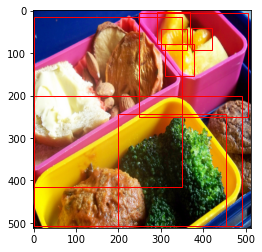

In [15]:
draw_image_with_bounding_boxes(*torch_dataset_train[0])

### Defining the model

#### Building the graph from node embeddings and bboxes

In [16]:
class GATorGraph(object):
  def __init__(self, on_data_created=None, method_name="simple_iou"):
    self.on_data_created = on_data_created
    self.edge_detection_method = self.select_edge_detetion_method(method_name)

  def select_edge_detetion_method(self, method_name):
    if method_name == "simple_iou":
      return self.simple_box_iou_edge_detection
    elif method_name == "complex_distance_semantic":
      return self.complex_distance_semantic_edge_detection

  
  @torch.no_grad()
  def __call__(self, x, batched_boxes, image_shapes):
    # print(f"GATorGraph: x shape before: {x.shape}")
    edges = []
    for index, (boxes, image_shape) in enumerate(zip(batched_boxes, image_shapes)):
      edge_list = self.edge_detection_method(boxes, x[index])
      # print(f"GATorGraph: x shape in for loop: {x[index].shape}") 
      data = pyg_data.Data(x=x[index], edge_index=edge_list.T, boxes=boxes, image_shape=image_shape)
      # print(f"GATorGraph: data shape: {data}")
      if self.on_data_created:
        self.on_data_created(data, index)
      edges.append(data)

    batched_edge_lists = pyg_data.Batch.from_data_list(edges)
    # print(f"GATorGraph: x shape after: {x.shape}")
    # print(f"GATorGraph: data num nodes: {edges[0]}")
    return batched_edge_lists

  def simple_box_iou_edge_detection(self, bboxes, _x):
      ious = box_iou(bboxes, bboxes)
      ious = torch.triu(ious, diagonal=1)
      return (ious > 0.5).nonzero(as_tuple=False)


  def complex_distance_semantic_edge_detection(self, bboxes, x):

    # central_boxes dim = (512,4)

    semantic_similarity = self.calcualte_semantic_similarity(x)
    # print(f"GATorGraph: semantic_similarity shape: {semantic_similarity.shape}")
    # print(f"GATorGraph: semantic_similarity count before filter: {len(semantic_similarity.nonzero(as_tuple=True)[0])}")
    spatial_relationships = self.calculate_complex_spatial_relationships(bboxes)
    # print(f"GATorGraph: spatial_relationships shape: {semantic_similarity.shape}")
    # print(f"GATorGraph: spatial_relationships count before filter: {len(spatial_relationships.nonzero(as_tuple=True)[0])}")

    edge_score = torch.add(semantic_similarity, spatial_relationships)
    # print(f"GATorGraph: edge_score shape: {semantic_similarity.shape}")

    # filter out overlapping boxes
    ious = box_iou(bboxes, bboxes)
    filter_mask = torch.where(ious > 0.5, 0, 1)
    # print(f"GATorGraph: edge_score count before filter: {len(edge_score.nonzero(as_tuple=True)[0])}")
    filtered_scores = torch.mul(edge_score, filter_mask)
    # print(f"GATorGraph: edge_score count after filter: {len(filtered_scores.nonzero(as_tuple=True)[0])}")

    # chose only upper triange so there would be no duplicate edges because the graph is undirected
    edge_score = torch.triu(filtered_scores, diagonal=1)

    # TODO we should multiply the cosine_similarity and gauss_distance matrices
    return edge_score.nonzero(as_tuple=False)

  def calculate_complex_spatial_relationships(self, bboxes, detection_distance = 250, distance_threshold=0.5):
    # transform central_boxes coordinates into center coordinates
    # TODO make a distance trheshold parameter
    centers = self.calculate_bbox_center(bboxes)
    euclidean_distance = torch.cdist(bboxes, bboxes)
    # constant to reduce the distance values
    k = np.log(distance_threshold)/(detection_distance)
    gauss_distance = torch.exp(torch.mul(k, euclidean_distance))
    _, top_k_distances_indexes = torch.topk(gauss_distance, k=16, dim= 1, largest=True)
    dist_matrix = torch.scatter(torch.zeros(euclidean_distance.shape, device=device),1, top_k_distances_indexes, 1)
    return dist_matrix

  def calcualte_semantic_similarity(self, x):
    # TODO we should generate a matrix of cosine similarities
    # x shape = (512,1024)
    # bboxes shape = (512, 4)
    # out shape = (512, 512)
    x_norm = x/x.norm(dim=1).unsqueeze(1)
    cosine_similarity = torch.matmul(x_norm,x_norm.T)
    # torch.set_printoptions(profile="default")
    # print(f"GATorGraph: semantic_similarity matrix\n: {cosine_similarity}")
    cosine_similarity = torch.where(cosine_similarity > 0.9, 1, 0)
    return cosine_similarity

  def calculate_bbox_center(self, bbox):
    x = (bbox[:,0] + bbox[:,2])/2
    # print(x)
    y = (bbox[:,1] + bbox[:,3])/2
    # print(y)
    res = torch.concat((x.unsqueeze(1), y.unsqueeze(1)), dim=1)
    # print(res)
    return res


#### Experimenting with various functions, operations and dimensions

In [17]:
t1 = torch.tensor([[1,2,3,4],[5,6,7,8]], dtype=torch.float)
# print(t1)
t2 = torch.tensor([[1,2,3,4],[5,6,7,8]], dtype=torch.float)
# print(t2)
# columns = (t1[:,2]/2 + t2[:,3]/2).unsqueeze(1)
# print(columns)
# x = (t1[:,0] + t1[:,2])/2
# print(x)
# y = (t1[:,1] + t1[:,3])/2
# print(y)
# res = torch.concat((x.unsqueeze(1), y.unsqueeze(1)), dim=1)
# print(res)
norm1 = t1/t1.norm(dim=1).unsqueeze(1)
norm2 = t2/t2.norm(dim=1).unsqueeze(1)
m = torch.matmul(norm1,norm1.T)
# print(m)
# sim = torch.cosine_similarity(torch.tensor([[1,2,3,4]],dtype=torch.float), torch.tensor([[5,6,7,8]],dtype=torch.float))
# print(sim)
# print(torch.mul(t1,t2))
# print(torch.triu(torch.tensor([[1,2,3],[4,5,6],[7,8,9]]), diagonal=1))
t3 = torch.tensor([[1,22,33],[44,5,6],[7,8,251]],dtype=torch.float)
print(t3)
k = np.log(0.5)/(250)
print(k)
gauss_distance = torch.exp(torch.mul(k, t3))
print(gauss_distance)
_, top_k_distances_indexes = torch.topk(gauss_distance,k=2, dim= 1, largest=True)
dist_matrix = torch.scatter(torch.zeros(gauss_distance.shape),1, top_k_distances_indexes, 1.)
print(dist_matrix)

tensor([[  1.,  22.,  33.],
        [ 44.,   5.,   6.],
        [  7.,   8., 251.]])
-0.0027725887222397813
tensor([[0.9972, 0.9408, 0.9126],
        [0.8852, 0.9862, 0.9835],
        [0.9808, 0.9781, 0.4986]])
tensor([[1., 1., 0.],
        [0., 1., 1.],
        [1., 1., 0.]])


# Sanity check

In [18]:
# Do not remove! Code doesn't work without it
print("AAAAAAAAAA")

AAAAAAAAAA


#### Main GAT stack module which processes image graph

In [19]:
class GATor(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers, heads, dropout, edge_dim=None):
    super(GATor, self).__init__()
    self.convs = nn.ModuleList()
    self.convs.append(GATv2Conv(in_channels=input_dim, out_channels=hidden_dim, heads=heads, edge_dim=edge_dim))
    for l in range(layers-1):
      self.convs.append(GATv2Conv(in_channels=heads * hidden_dim, out_channels=hidden_dim, heads=heads, edge_dim=edge_dim))
    # post-message-passing
    self.post_mp = nn.Sequential(
      nn.Linear(heads * hidden_dim, hidden_dim), nn.Dropout(dropout), 
      nn.Linear(hidden_dim, output_dim))
    self.dropout = dropout
    self.num_layers = layers


  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    # print(f"GATor x shape: {x.shape}")  
    # print(f"GATor edge_index shape: {edge_index.shape}")
    for i in range(self.num_layers):
      # print(f"GATor current layer index: {i}")
      # print(f"GATor current x shape: {x.shape}")
      x = self.convs[i](x, edge_index)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.post_mp(x)
    return x

#### Wrapper module which caches bboxes and image shapes that are required for graph creation

In [20]:
class MultiScaleRoIAlignWrapper(nn.Module):
  def __init__(self, roi_align):
    super(MultiScaleRoIAlignWrapper, self).__init__()
    self.roi_align = roi_align

  def forward(self, x, boxes, image_shapes):
    # print(f"MULTI SCALE ROI: X dictionary: {x}")
    # print(f"MULTI SCALE ROI: boxes len: {len(boxes)}")
    # print(f"MULTI SCALE ROI: boxe[0] shape: {boxes[0].shape}")
    # print(f"MULTI SCALE ROI: image_shapes len: {len(image_shapes)}")
    # for a in x:
    #   print(f"MULTI SCALE ROI: shapes o elements in X: {a}")
    ret_val = self.roi_align(x, boxes, image_shapes)
    # print(f"MULTI SCALE ROI: retval: {ret_val}")
    # print(f"MULTI SCALE ROI: retval shape: {ret_val.shape}")
    cached['boxes'] = boxes
    cached['image_shapes'] = image_shapes
    return ret_val

#### Wrapper module which initializes graph creating that will be placed after the model outputs final embeddings

In [21]:
class TwoMLPHeadWrapper(nn.Module):
  def __init__(self, box_head, gator_graph, gator):
    super(TwoMLPHeadWrapper, self).__init__()
    self.box_head = box_head
    self.gator_graph = gator_graph
    self.gator = gator

  def forward(self, x):
    # print(f"TwoMLPHeadWrapper: x shape: {x.shape}")
    node_features = self.box_head(x)
    # print(f"TwoMLPHeadWrapper: node_features shape: {node_features.shape}")
    B = len(cached['boxes'])
    graph = self.gator_graph(node_features.view(B,-1, node_features.shape[1]), cached['boxes'], cached['image_shapes'])
    ret_val = self.gator(graph)
    # print(f"TwoMLPHeadWrapper: Evo me")
    return ret_val

#### Graph message passing for custom layer building

In [22]:
class GATorLayer(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None
        


        self.lin_l = Linear(in_channels, out_channels*self.heads)


        self.lin_r = self.lin_l


        self.att_l = Parameter(torch.Tensor(1, self.heads, out_channels))
        self.att_r = Parameter(torch.Tensor(1, self.heads, out_channels))
        self.attention = Parameter(torch.Tensor(1, self.heads, out_channels))


        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        # print(f"\n========Forward========")
        # print(f"x shape: {x.shape}")
        # print(f"Edge index shape {edge_index.shape}")
        # print(f"att_l shape: {self.att_l.shape}")
        # print(f"att_r shape: {self.att_r.shape}")


        wh_l = self.lin_r(x).view(-1, H, C)
        wh_r = self.lin_r(x).view(-1, H, C)
        # print(f"whl shape: {wh_l.shape}")
        # print(f"whr shape: {wh_r.shape}")

        alpha_l = wh_l
        alpha_r = wh_r
        # print(f"alpha_l shape: {alpha_l.shape}")
        # print(f"alpha_r shape: {alpha_r.shape}")

        out = self.propagate(edge_index,x=(wh_l, wh_r), size=size, alpha=(alpha_l, alpha_r))
        # print(f"Shape of propagate out: {out.shape}")

        out = out.view(-1, H*C)
        # print(f"Shape of out after shape transformation to [N, H*C]: {out.shape}")

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        # Because TwoMLPHead layer from FasterRCNN gives embeddings for region proposals
        # that are generated to be ready for classification and regression
        # we can just use cosine similarity between the nodes to determine semantic similarity
        # If semantic similarity is high, the central node i should pay more attention to that message

        # print(f"\n========Message funnction========")
        # print(f"x_j shape: {x_j.shape}")
        # print(f"Alpha_j shape: {alpha_j.shape}")
        # print(f"Alpha_i shape: {alpha_i.shape}")
        # print(f"Index: {index.shape}")
        # print(f"ptr shape: {ptr}")
        # print(f"size_i: {size_i}")

        # TODO select just rows from x_j based on index
        # alpha_i should be the central node embedding
        cos_sim = torch.nn.CosineSimilarity(alpha_i, x_j)

        attention = torch.mul(cos_sim, x_j)

        attention = softmax(attention, ptr if ptr else index)
        attention = F.dropout(att, self.dropout)

        out = attention
        # print(f"out shape from message function should be [E, H, C]: {out.shape}")

        return out


    def aggregate(self, inputs, index, dim_size = None):

        out = torch_scatter.scatter(inputs, index = index, dim = self.node_dim, dim_size = dim_size, reduce = "sum")
    
        return out

### Building the model

In [25]:
def build_model():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  gator_graph = GATorGraph(method_name="complex_distance_semantic")
  gator = GATor(input_dim=1024, hidden_dim=1024, output_dim=1024, layers=2, heads=1, dropout=0.5, edge_dim=None)
  # gat = GATModule(model.roi_heads.box_head, gator_graph)
  # model.rpn = RPNWrapper(model.rpn)
  model.roi_heads.box_roi_pool = MultiScaleRoIAlignWrapper(model.roi_heads.box_roi_pool)
  model.roi_heads.box_head = TwoMLPHeadWrapper(model.roi_heads.box_head, gator_graph, gator)
  # model.box_predictor.reset_parameters()
  # model.roi_heads.box_head = gat
  return model

In [26]:
cached = {}
model = build_model()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Defining PyTorch dataloaders

In [27]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [31]:
data_loader_train = DataLoader(torch_dataset_train, batch_size=16, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(torch_dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

### Training using standard COCO training pipeline

In [32]:
def save_model(model, path):
  torch.save(model.state_dict(), path)

In [33]:
def train(model, train_loader, test_loader, n_epochs, save_dir='models'):
  if not osp.exists(save_dir):
    os.mkdir(save_dir)
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.train()
  for param in model.parameters():
    param.requires_grad = False
  for param in model.roi_heads.box_head.gator.parameters():
    param.requires_grad = True
  for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True
  model.to(device)
  params = [p for p in model.parameters() if p.requires_grad]
#   optimizer = torch.optim.Adam(params)
  optimizer = torch.optim.SGD(params, lr=0.002, momentum=0.9, weight_decay=0.0005)

  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

  for epoch in range(n_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    
    # save the state dict
    torch.save(model.state_dict(), osp.join(save_dir, f'faster-rcnn-gator-epochs-{epoch}.pt'))
    
    # evaluate on the test dataset
    evaluate(model, test_loader, device=device)


In [35]:
train(model, data_loader_train, data_loader_test, n_epochs=1, save_dir='models')

/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272178570/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [   0/7330]  eta: 2:41:36  lr: 0.000004  loss: 4.6400 (4.6400)  loss_classifier: 3.8963 (3.8963)  loss_box_reg: 0.5660 (0.5660)  loss_objectness: 0.1064 (0.1064)  loss_rpn_box_reg: 0.0712 (0.0712)  time: 1.3228  data: 0.3394  max mem: 5019
Epoch: [0]  [  10/7330]  eta: 3:06:55  lr: 0.000024  loss: 4.4776 (4.4950)  loss_classifier: 3.8607 (3.8475)  loss_box_reg: 0.5450 (0.5498)  loss_objectness: 0.0429 (0.0473)  loss_rpn_box_reg: 0.0488 (0.0503)  time: 1.5322  data: 0.2710  max mem: 5069
Epoch: [0]  [  20/7330]  eta: 3:00:20  lr: 0.000044  loss: 4.3805 (4.3187)  loss_classifier: 3.6918 (3.6635)  loss_box_reg: 0.5397 (0.5578)  loss_objectness: 0.0429 (0.0481)  loss_rpn_box_reg: 0.0488 (0.0493)  time: 1.4881  data: 0.2644  max mem: 5069
Epoch: [0]  [  30/7330]  eta: 2:35:28  lr: 0.000064  loss: 3.6868 (3.9984)  loss_classifier: 3.0371 (3.3290)  loss_box_reg: 0.5913 (0.5687)  loss_objectness: 0.0449 (0.0492)  loss_rpn_box_reg: 0.0507 (0.0515)  time: 1.1380  data: 0.2644  max me

In [37]:
model.load_state_dict(torch.load('models/faster-rcnn-gator-epochs-1.pt'))

<All keys matched successfully>

### Unmodified FasterRCNN evaluation results

In [ ]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.to(device)
evaluate(faster_rcnn, data_loader_test, device=device)

creating index...
index created!
Test:  [  0/906]  eta: 0:04:01  model_time: 0.1577 (0.1577)  evaluator_time: 0.0070 (0.0070)  time: 0.2662  data: 0.1005  max mem: 2612
Test:  [100/906]  eta: 0:02:44  model_time: 0.1047 (0.1031)  evaluator_time: 0.0047 (0.0088)  time: 0.2019  data: 0.0877  max mem: 2612
Test:  [200/906]  eta: 0:02:23  model_time: 0.1093 (0.1041)  evaluator_time: 0.0067 (0.0087)  time: 0.2043  data: 0.0876  max mem: 2612
Test:  [300/906]  eta: 0:02:02  model_time: 0.1034 (0.1047)  evaluator_time: 0.0042 (0.0082)  time: 0.1978  data: 0.0849  max mem: 2612
Test:  [400/906]  eta: 0:01:42  model_time: 0.1031 (0.1051)  evaluator_time: 0.0050 (0.0081)  time: 0.2032  data: 0.0884  max mem: 2612
Test:  [500/906]  eta: 0:01:22  model_time: 0.1120 (0.1054)  evaluator_time: 0.0041 (0.0081)  time: 0.2064  data: 0.0863  max mem: 2612
Test:  [600/906]  eta: 0:01:02  model_time: 0.1023 (0.1055)  evaluator_time: 0.0075 (0.0080)  time: 0.2102  data: 0.0958  max mem: 2612
Test:  [700/906

### Evaluation using standard COCO pipeline


#### Converting torch predictions to Fiftyone compatible objects

In [ ]:
def convert_torch_predictions(preds, det_id, s_id, w, h, classes):
  # Convert the outputs of the torch model into a FiftyOne Detections object
  dets = []
  for bbox, label, score in zip(preds["boxes"].cpu().detach().numpy(), preds["labels"].cpu().detach().numpy(), preds["scores"].cpu().detach().numpy()):
    # Parse prediction into FiftyOne Detection object
    x0,y0,x1,y1 = bbox
    coco_obj = fouc.COCOObject(det_id, s_id, int(label), [x0, y0, x1-x0, y1-y0])
    det = coco_obj.to_detection((w,h), classes)
    det["confidence"] = float(score)
    dets.append(det)
    det_id += 1
        
  detections = fo.Detections(detections=dets)
      
  return detections, det_id

#### Adding detections to Fiftyone dataset so they can be inspected in the Fiftyone client

In [ ]:
def add_detections(model, torch_dataset, view, field_name="predictions"):
  # Run inference on a dataset and add results to FiftyOne
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  model.eval()
  model.to(device)
  image_paths = torch_dataset.img_paths
  classes = torch_dataset.classes
  det_id = 0
  
  print("Adding detections to FiftyOne view...")
  with fo.ProgressBar() as pb:
    for img, targets in pb(torch_dataset):
      # Get FiftyOne sample indexed by unique image filepath
      img_id = int(targets["image_id"][0])
      img_path = image_paths[img_id]
      sample = view[img_path]
      s_id = sample.id
      w = sample.metadata["width"]
      h = sample.metadata["height"]
      
      # Inference
      preds = model(img.unsqueeze(0).to(device))[0]
      
      detections, det_id = convert_torch_predictions(preds, det_id, s_id, w, h, classes)
      
      sample[field_name] = detections
      sample.save()

#### Running evaluation

In [ ]:
add_detections(model, torch_dataset_test, test_view)

results = fo.evaluate_detections(test_view, "predictions", eval_key="eval", compute_mAP=True) 
print(results.mAP())

Adding detections to FiftyOne view...
 100% |█████████████████| 906/906 [4.5m elapsed, 0s remaining, 3.4 samples/s]      
Evaluating detections...
 100% |█████████████████| 906/906 [1.3m elapsed, 0s remaining, 12.3 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 906/906 [2.0m elapsed, 0s remaining, 6.9 samples/s]      
0.29627496266118764


In [ ]:
results.plot_confusion_matrix()

In [ ]:
results.plot_pr_curves()

In [ ]:
session.view = test_view

## Different training approach

### Processing COCO dataset to Torch geometric data dataset to speed up training by saving graphs created from precomputed embedding for each image in the dataset (~1 TB)

In [ ]:
class TorchGemetricCocoRelationalGraphDataaset(pyg_data.Dataset):
  def __init__(self, root, model, coco_loader, phase, transform=None, pre_transform=None, pre_filter=None):
    if phase not in ['train', 'test']:
      raise Exception(f"Unexpected value for phase argument: '{phase}'. Expected 'train' or 'test'.")
    self._phase = phase
    self._processed_file_names = []
    self._model = model
    self._coco_loader = coco_loader
    super().__init__(root, transform, pre_transform, pre_filter)

  @property
  def processed_file_names(self):
      return self._processed_file_names

  def process(self):
    batch_idx = 0

    def build_saver(targets):
      def saver(data, in_batch_idx):
        data_idx = batch_idx + in_batch_idx
        data.y = targets[in_batch_idx]
        file_path = osp.join(self.processed_dir, f'data_{data_idx}.pt')
        torch.save(data, file_path)
        self._processed_file_names.append(file_path)
      return saver

    if self._phase == 'train':
      self._model.train()
    else:
      self._model.eval()

    self._model.to(device)

    with fo.ProgressBar() as pb:
      for images, targets in pb(self._coco_loader):
        self._register_callback(build_saver(targets))
        batch_size = len(images)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        self._model(images, targets)
        batch_idx += batch_size

    self._register_callback()

  def len(self):
    return len(self._processed_file_names)

  def get(self, idx):
    data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
    return data

  def _register_callback(self, callback=None):
    self._model.roi_heads.box_head.gator_graph.on_data_created = callback

In [ ]:
graph_dataset_train = TorchGemetricCocoRelationalGraphDataaset('/root/graph-data/train', model, data_loader_train, 'train')
graph_dataset_test = TorchGemetricCocoRelationalGraphDataaset('/root/graph-data/test', model, data_loader_test, 'test')

### Defining GATorHidra extension model for object detection

In [ ]:
class GATorPredictor(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(GATorPredictor, self).__init__()
    self.cls_score = nn.Linear(in_channels, num_classes)
    self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

  def forward(self, x):
    if x.dim() == 4:
      assert list(x.shape[2:]) == [1, 1]
    x = x.flatten(start_dim=1)
    scores = self.cls_score(x)
    bbox_deltas = self.bbox_pred(x)
    return scores, bbox_deltas

#### Self explanatory

In [ ]:
class GATorHidra(torchvision.models.detection.roi_heads.RoIHeads):
  def __init__(self,
      # GATor
      gator_input_dim=1024,
      gator_hidden_dim=1024,
      gator_output_dim=1024,
      gator_num_layers=2,
      gator_num_heads=8,
      gator_dropout=0.5,
      gator_edge_dim=None,
      gator_num_classes=91,
      # Faster R-CNN training
      fg_iou_thresh=0.5,
      bg_iou_thresh=0.5,
      batch_size_per_image=512,
      positive_fraction=0.25,
      bbox_reg_weights=None,
      # Faster R-CNN inference
      score_thresh=0.05,
      nms_thresh=0.5,
      detections_per_img=100,
    ):
    super(GATorHidra, self).__init__(
        box_roi_pool=None,
        box_head=None,
        box_predictor=None,
        # Faster R-CNN training
        fg_iou_thresh=fg_iou_thresh,
        bg_iou_thresh=bg_iou_thresh,
        batch_size_per_image=batch_size_per_image,
        positive_fraction=positive_fraction,
        bbox_reg_weights=bbox_reg_weights,
        # Faster R-CNN inference
        score_thresh=score_thresh,
        nms_thresh=nms_thresh,
        detections_per_img=detections_per_img,
    )

    self.gator = GATor(input_dim=gator_input_dim,
                       hidden_dim=gator_hidden_dim,
                       output_dim=gator_output_dim,
                       layers=gator_num_layers,
                       heads=gator_num_heads, 
                       dropout=gator_dropout, 
                       edge_dim=gator_edge_dim)
    self.predictor = GATorPredictor(in_channels=gator_output_dim, 
                                    num_classes=gator_num_classes)

  def forward(self, data):
    proposals, targets, image_shapes = data.boxes, data.y, data.image_shape
    box_features = self.gator(data)
    class_logits, box_regression = self.predictor(box_features)

    if self.training:
      proposals, matched_idxs, labels, regression_targets = self.select_training_samples(proposals, targets)
      loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
      return {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    else:
      boxes, scores, labels = self.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
      num_images = len(boxes)
      result = []
      for i in range(num_images):
        result.append(
            {
              "boxes": boxes[i],
              "labels": labels[i],
              "scores": scores[i],
            }
        )
      return result

In [ ]:
gator_hidra = GATorHidra()
gator_hidra.to(device)

### Novel training approach using our torch geometric dataset (only for chads)

In [ ]:
def graph_collate_function(data_list):
  batch = pyg_data.Batch.from_data_list(data_list)
  y = [{k: v for k, v in data.y.items()} for data in data_list]
  proposals = [data.boxes for data in data_list]
  batch.y = y
  batch.boxes = proposals
  return batch

In [ ]:
class BatchingDataLoader(torch.utils.data.DataLoader):
  def __init__(self, dataset, batch_size=1, shuffle=False, **kwargs):
    super(BatchingDataLoader, self).__init__(dataset, batch_size, shuffle, collate_fn=graph_collate_function, **kwargs)

In [ ]:
pyg_data_loader_train = BatchingDataLoader(graph_dataset_train, batch_size=4, shuffle=False)
pyg_data_loader_test = BatchingDataLoader(graph_dataset_test, batch_size=1)

In [ ]:
# https://github.com/pytorch/vision/blob/afda28accbc79035384952c0359f0e4de8454cb3/torchvision/models/detection/roi_heads.py

def fastrcnn_loss(class_logits, box_regression, labels, regression_targets):
  # type: (Tensor, Tensor, List[Tensor], List[Tensor]) -> Tuple[Tensor, Tensor]
  """
  Computes the loss for Faster R-CNN.

  Args:
      class_logits (Tensor)
      box_regression (Tensor)
      labels (list[BoxList])
      regression_targets (Tensor)

  Returns:
      classification_loss (Tensor)
      box_loss (Tensor)
  """

  labels = torch.cat(labels, dim=0)
  regression_targets = torch.cat(regression_targets, dim=0)

  classification_loss = F.cross_entropy(class_logits, labels)

  # get indices that correspond to the regression targets for
  # the corresponding ground truth labels, to be used with
  # advanced indexing
  sampled_pos_inds_subset = torch.where(labels > 0)[0]
  labels_pos = labels[sampled_pos_inds_subset]
  N, num_classes = class_logits.shape
  box_regression = box_regression.reshape(N, box_regression.size(-1) // 4, 4)

  box_loss = F.smooth_l1_loss(
    box_regression[sampled_pos_inds_subset, labels_pos],
    regression_targets[sampled_pos_inds_subset],
    beta=1 / 9,
    reduction="sum",
  )
  box_loss = box_loss / labels.numel()

  return classification_loss, box_loss

In [ ]:
def train_one_epoch_geometric(model, optimizer, train_loader, device, epoch, print_freq=10):
  model.train()
  metric_logger = utils.MetricLogger(delimiter="  ")
  metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
  header = 'Epoch: [{}]'.format(epoch)

  lr_scheduler = None
  if epoch == 0:
    warmup_factor = 1. / 1000
    warmup_iters = min(1000, len(train_loader) - 1)

    lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

  for data_batch in metric_logger.log_every(train_loader, print_freq, header):
    # Put batch to device
    data_batch.y = [{k: v.to(device) for k, v in y.items()} for y in data_batch.y]
    data_batch.x = data_batch.x.to(device)
    data_batch.boxes = [box.to(device) for box in data_batch.boxes]
    loss_dict = model(data_batch)

    losses = sum(loss for loss in loss_dict.values())

    # reduce losses over all GPUs for logging purposes
    loss_dict_reduced = utils.reduce_dict(loss_dict)
    losses_reduced = sum(loss for loss in loss_dict_reduced.values())

    loss_value = losses_reduced.item()

    if not math.isfinite(loss_value):
      print("Loss is {}, stopping training".format(loss_value))
      print(loss_dict_reduced)
      sys.exit(1)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if lr_scheduler is not None:
      lr_scheduler.step()

    metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
    metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [ ]:
def train_geometric(model, train_loader, test_loader, n_epochs):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.train()
  model.to(device)
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

  for epoch in range(n_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch_geometric(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, test_loader, device=device)

In [ ]:
train_geometric(gator_hidra, pyg_data_loader_train, pyg_data_loader_test, n_epochs=10)